In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import time
from scipy.linalg import cho_factor, cho_solve

from jax import grad,jit,random, jacfwd
import jax.numpy as jnp

%matplotlib inline

In [2]:
lamb = 0.0001

# Loading Data

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img.reshape(1,64*64))
    images = np.array(images)
    images = images.reshape(images.shape[0],64*64)/255
    return images

In [4]:
X_cats = load_images_from_folder("dataset_cats/cats/")
y_cats = np.ones((X_cats.shape[0],1))
X_noncats = load_images_from_folder("dataset_cats/non-cats/")
y_noncats = np.zeros((X_noncats.shape[0],1))

X_data = np.append(X_cats,X_noncats, axis=0)
X_data = np.append(np.ones((X_data.shape[0],1)),X_data,axis = 1)
y_data = np.append(y_cats,y_noncats, axis=0)


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=9)

y = [1.]


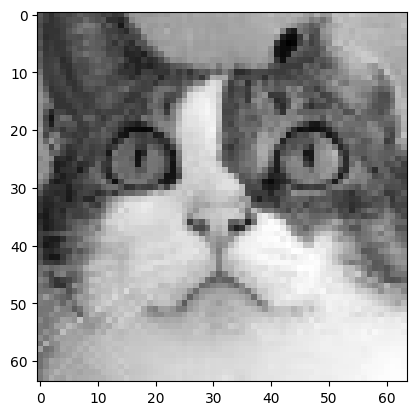

In [5]:
# Example of a picture
index = 0
plt.imshow(X_train[index,1:].reshape((64,64)),cmap="gray")
print ("y = " + str(y_train[index]))

# Common Functions

In [6]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))    
    return s

In [7]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    assert(w.shape == (dim,1))
    return w

In [8]:
def mini_batch(X_in,y_in,size,i):
    size = int(size)
    n = int(i%(X_in.shape[0]/size))
    return X_in[n*size:(n+1)*size], y_in[n*size:(n+1)*size]    

In [9]:
def predict(w, X):
    m = X.shape[0]
    Y_prediction = np.zeros((m,1))
    
    A = sigmoid(X@w)
    
    Y_prediction = (A >= 0.5) * 1.0    
    return Y_prediction

In [10]:
def calc_accuracy(w,X,y):
    return 100 - np.mean(np.abs(predict(w,X) - y)) * 100

In [11]:
@jit
def sigmoid_jax(w,X):
    z = X@w
    s = 1/(1+jnp.exp(-z))    
    return s

In [12]:
def cost_function_jax(w,X_train,y_real,lamb=0):
    m = X_train.shape[1]
    y_predicted = np.array(sigmoid_jax(w,X_train))
    term1 = np.copy(y_predicted)
    term1[y_real == 0] = 1
    term2 = 1 - np.copy(y_predicted)
    term2[y_real == 1] = 1
    cost = np.sum(((- np.log(term1))*y_real + (-np.log(term2))*(1-y_real)))/m  + lamb*w.T@w
    return cost

In [13]:
@jit
def gradient_w_jax(w,X,y,lamb=0):
    lamb = 0.00001
    return X.T@(sigmoid_jax(w,X)-y)/(X.shape[1]) + 2*lamb*w

In [14]:
Hessian_M = jit(jacfwd(lambda w,X,y,V,lamb : V.T@gradient_w_jax(w,X,y,lamb),argnums=0)) #function hessian times a matrix -- each line will be the product of the hessian with a vector, so needs to be transposed.

# Optimization - Our Method

In [15]:
def optimize_our(w, X_train, y_train, learning_rate, num_iterations, n_directions, lamb, print_cost = False):    
    costs = []
    acc = []
    eps=1e-8

    m = X_train.shape[1]
    size = 192
    
    init_time = time.time()
        
    for i in range(num_iterations):
      
        X_train_batch, y_train_batch = mini_batch(X_train,y_train,size,i)
        
        grad_w = gradient_w_jax(w,X_train_batch,y_train_batch,lamb)
        if i == 0:
            V = grad_w
            V1 = grad_w
            dw = grad_w
        else:            
            if i < n_directions:
                V1 = jnp.append(V,grad_w,axis = 1)
                V,_ = jnp.linalg.qr(V1)                
                Hv= Hessian_M(w,X_train_batch,y_train_batch,V,lamb).reshape(i+1,m).T
            else:
                V1 = jnp.append(V[:,1:],grad_w, axis = 1)
                V,_ = jnp.linalg.qr(V1)
                Hv= Hessian_M(w,X_train_batch,y_train_batch,V,lamb).reshape(n_directions,m).T

            #y = jnp.linalg.inv(V.T@Hv)@V.T@grad_w
            L = cho_factor(V.T@Hv)
            y = cho_solve(L,V.T@grad_w)
            dw = V@y       

        w = w - (learning_rate*dw)

        if print_cost:         
            cost = cost_function_jax(w,X_train,y_train,lamb)
            costs.append(cost)
            acc.append(calc_accuracy(w,X_test,y_test))
            print ("Cost after iteration %i: %f" %(i, cost))
            
    elapsed = time.time() - init_time
    print("elapsed time: " + str(elapsed))
            
    return w,costs,acc

In [16]:
w = initialize_with_zeros(X_train.shape[1])
w_our,costs_our,acc_our = optimize_our(w, X_train, y_train, 0.2, int(101),10, lamb, True)

Cost after iteration 0: 0.319008
Cost after iteration 1: 0.302801
Cost after iteration 2: 0.288651
Cost after iteration 3: 0.276838
Cost after iteration 4: 0.269818
Cost after iteration 5: 0.256312
Cost after iteration 6: 0.246520
Cost after iteration 7: 0.237285
Cost after iteration 8: 0.223965
Cost after iteration 9: 0.214297
Cost after iteration 10: 0.208362
Cost after iteration 11: 0.202704
Cost after iteration 12: 0.198353
Cost after iteration 13: 0.194749
Cost after iteration 14: 0.187762
Cost after iteration 15: 0.184156
Cost after iteration 16: 0.178543
Cost after iteration 17: 0.170890
Cost after iteration 18: 0.164912
Cost after iteration 19: 0.163040
Cost after iteration 20: 0.161972
Cost after iteration 21: 0.156756
Cost after iteration 22: 0.152614
Cost after iteration 23: 0.151892
Cost after iteration 24: 0.151204
Cost after iteration 25: 0.148464
Cost after iteration 26: 0.148847
Cost after iteration 27: 0.145103
Cost after iteration 28: 0.144982
Cost after iteration 29:

# Optimization - Adam

In [17]:
def optimize_adam(w,X_train, y_train, learning_rate, beta1, beta2, num_iterations, lamb, print_cost = False):    
    costs = []
    acc = []
    
    eps=1e-8

    m = X_train.shape[1]
    size = 192
    
    init_time = time.time()
        
    for i in range(num_iterations):
        X_train_batch, y_train_batch = mini_batch(X_train,y_train,size,i)
        
        A = sigmoid(X_train_batch@w)
        grad_w = gradient_w_jax(w,X_train_batch,y_train_batch,lamb)#(X_train_batch.T@(A-y_train_batch))/size
        
        if i == 0:
            mw = grad_w
            vw = (grad_w**2).reshape(X_train.shape[1],1)
        else:
            mw = beta1*mw + (1-beta1)*grad_w
            vw = beta2*vw + (1-beta2)*((grad_w**2).reshape(X_train.shape[1],1))
        
        mw_hat = mw/(1-beta1**(i+1))
        vw_hat = vw/(1-beta2**(i+1))        
        
        alfa = learning_rate
        
        w = w - (alfa*mw_hat/(np.sqrt(vw_hat)+eps))
        
        if print_cost:
            A = sigmoid(X_train@w)
            cost = cost_function_jax(w,X_train,y_train,lamb)#np.sum(((- np.log(A))*y_train + (-np.log(1-A))*(1-y_train)))/m
            costs.append(cost)
            acc.append(calc_accuracy(w,X_test,y_test))
            print ("Cost after iteration %i: %f" %(i, cost))
            
    elapsed = time.time() - init_time
    print("elapsed time: " + str(elapsed))
            
    return w,costs,acc
    

In [18]:
w = initialize_with_zeros(X_train.shape[1])
w_adam,costs_adam,acc_adam = optimize_adam(w, X_train, y_train, 0.005, 0.9, 0.999, int(101), lamb, True)

Cost after iteration 0: 0.304978
Cost after iteration 1: 0.281222
Cost after iteration 2: 0.284062
Cost after iteration 3: 0.276078
Cost after iteration 4: 0.298580
Cost after iteration 5: 0.268889
Cost after iteration 6: 0.281481
Cost after iteration 7: 0.309917
Cost after iteration 8: 0.275467
Cost after iteration 9: 0.281749
Cost after iteration 10: 0.307522
Cost after iteration 11: 0.288444
Cost after iteration 12: 0.266784
Cost after iteration 13: 0.280897
Cost after iteration 14: 0.280819
Cost after iteration 15: 0.263069
Cost after iteration 16: 0.261540
Cost after iteration 17: 0.260313
Cost after iteration 18: 0.255372
Cost after iteration 19: 0.250160
Cost after iteration 20: 0.247551
Cost after iteration 21: 0.246214
Cost after iteration 22: 0.243899
Cost after iteration 23: 0.238190
Cost after iteration 24: 0.241549
Cost after iteration 25: 0.235631
Cost after iteration 26: 0.230076
Cost after iteration 27: 0.240591
Cost after iteration 28: 0.232606
Cost after iteration 29:

# Optimization - SGD

In [19]:
def optimize_SGD(w, X_train, y_train, learning_rate, beta, num_iterations, lamb,print_cost = False):    
    costs = []
    acc = []

    m = X_train.shape[1]
    size = 192
    
    init_time = time.time()
        
    for i in range(num_iterations):
        X_train_batch, y_train_batch = mini_batch(X_train,y_train,size,i)
        
        
        A = sigmoid(X_train_batch@w)
        grad_w = gradient_w_jax(w,X_train_batch,y_train_batch,lamb)#(X_train_batch.T@(A-y_train_batch))/size
        
        if i == 0:
            mgrad_w = grad_w
        else:
            mgrad_w = beta*mgrad_w + (1-beta)*grad_w          
        

        alfa = learning_rate
        
        w = w - (alfa*mgrad_w)
        
        if print_cost:
            A = sigmoid(X_train@w)
            cost = cost_function_jax(w,X_train,y_train,lamb)#np.sum(((- np.log(A))*y_train + (-np.log(1-A))*(1-y_train)))/m
            costs.append(cost)
            acc.append(calc_accuracy(w,X_test,y_test))
            print ("Cost after iteration %i: %f" %(i, cost))
            
    elapsed = time.time() - init_time
    print("elapsed time: " + str(elapsed))
            
    return w,costs,acc
    

In [20]:
w = initialize_with_zeros(X_train.shape[1])
w_sgd,costs_sgd,acc_sgd = optimize_SGD(w, X_train, y_train, 0.2, 0.9, int(101), lamb, True) #0.050432

Cost after iteration 0: 0.319008
Cost after iteration 1: 0.314334
Cost after iteration 2: 0.309281
Cost after iteration 3: 0.304898
Cost after iteration 4: 0.300324
Cost after iteration 5: 0.295372
Cost after iteration 6: 0.291045
Cost after iteration 7: 0.287723
Cost after iteration 8: 0.285354
Cost after iteration 9: 0.283077
Cost after iteration 10: 0.280604
Cost after iteration 11: 0.278191
Cost after iteration 12: 0.276112
Cost after iteration 13: 0.273904
Cost after iteration 14: 0.272509
Cost after iteration 15: 0.271500
Cost after iteration 16: 0.270531
Cost after iteration 17: 0.268914
Cost after iteration 18: 0.267603
Cost after iteration 19: 0.266498
Cost after iteration 20: 0.265571
Cost after iteration 21: 0.264813
Cost after iteration 22: 0.264347
Cost after iteration 23: 0.263539
Cost after iteration 24: 0.262697
Cost after iteration 25: 0.261964
Cost after iteration 26: 0.261315
Cost after iteration 27: 0.260736
Cost after iteration 28: 0.260161
Cost after iteration 29:

# Optimization - AdaGrad

In [21]:
def optimize_AdaGrad(w, X_train, y_train, learning_rate, num_iterations, lamb, print_cost = False):    
    costs = []
    acc = []
    eps=1e-8

    m = X_train.shape[1]
    size = 192
    
    init_time = time.time()
        
    for i in range(num_iterations):
        X_train_batch, y_train_batch = mini_batch(X_train,y_train,size,i)
        
        A = sigmoid(X_train_batch@w)
        grad_w = gradient_w_jax(w,X_train_batch,y_train_batch,lamb)#(X_train_batch.T@(A-y_train_batch))/size

        
        if i==0:
            grad_past_w = grad_w
            
            w = w - (learning_rate*grad_w)
  
        else:
            grad_past_w = np.append(grad_past_w,grad_w,axis=1)
             
            G_w = (grad_past_w*grad_past_w).sum(axis=1).reshape(X_train.shape[1],1)
            
            w = w - (learning_rate*grad_w/(np.sqrt(G_w)+eps))

               
        
        if print_cost:
            A = sigmoid(X_train@w)            
            cost = cost_function_jax(w,X_train,y_train,lamb)#np.sum(((- np.log(A))*y_train + (-np.log(1-A))*(1-y_train)))/m
            costs.append(cost)
            acc.append(calc_accuracy(w,X_test,y_test))
            print ("Cost after iteration %i: %f" %(i, cost))
            
    elapsed = time.time() - init_time
    print("elapsed time: " + str(elapsed))
            
    return w,costs,acc    

In [22]:
w = initialize_with_zeros(X_train.shape[1])
w_adagrad,costs_adagrad,acc_adagrad = optimize_AdaGrad(w, X_train, y_train, 0.001, int(101), lamb, True)

Cost after iteration 0: 0.324799
Cost after iteration 1: 0.312478
Cost after iteration 2: 0.347337
Cost after iteration 3: 0.325559
Cost after iteration 4: 0.311263
Cost after iteration 5: 0.302458
Cost after iteration 6: 0.295628
Cost after iteration 7: 0.296709
Cost after iteration 8: 0.292642
Cost after iteration 9: 0.287325
Cost after iteration 10: 0.285845
Cost after iteration 11: 0.284896
Cost after iteration 12: 0.284617
Cost after iteration 13: 0.287605
Cost after iteration 14: 0.281465
Cost after iteration 15: 0.280532
Cost after iteration 16: 0.279550
Cost after iteration 17: 0.281415
Cost after iteration 18: 0.279521
Cost after iteration 19: 0.277314
Cost after iteration 20: 0.276618
Cost after iteration 21: 0.276105
Cost after iteration 22: 0.276387
Cost after iteration 23: 0.278035
Cost after iteration 24: 0.274120
Cost after iteration 25: 0.273517
Cost after iteration 26: 0.272788
Cost after iteration 27: 0.274475
Cost after iteration 28: 0.272704
Cost after iteration 29:

# Results

In [23]:
acc_our = np.array(acc_our)
costs_our = np.array(costs_our).reshape(-1)

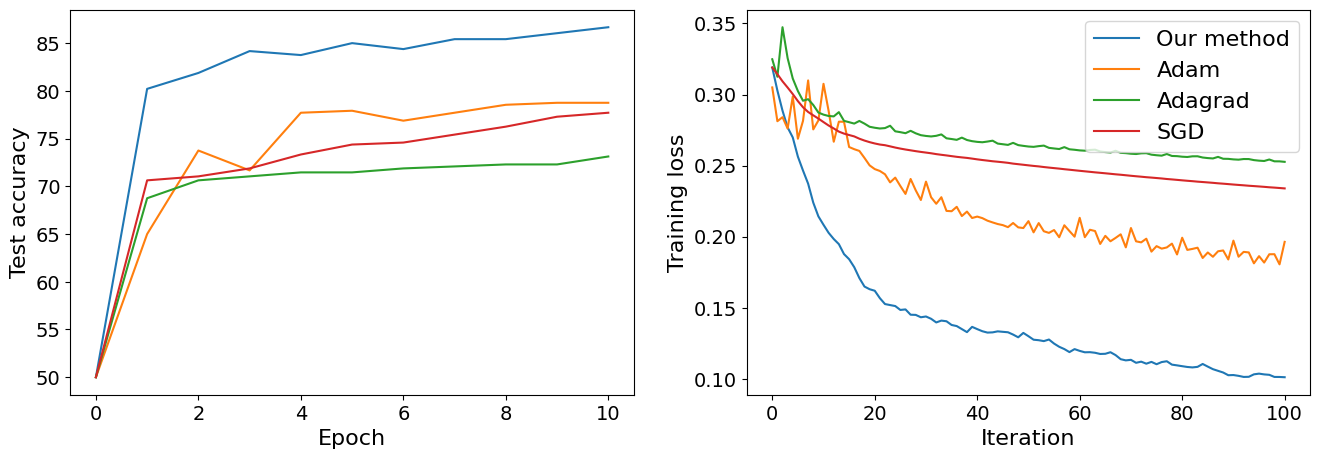

In [24]:
ig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

acc_our_plot = [acc_our[i] for i in range(1,len(acc_our)) if i%10==0]
acc_adam_plot = [acc_adam[i] for i in range(1,len(acc_adam)) if i%10==0]
acc_adagrad_plot = [acc_adagrad[i] for i in range(1,len(acc_adagrad)) if i%10==0]
acc_sgd_plot = [acc_sgd[i] for i in range(1,len(acc_sgd)) if i%10==0]


ax[0].plot(np.append(50,acc_our_plot))
ax[0].plot(np.append(50,acc_adam_plot))
ax[0].plot(np.append(50,acc_adagrad_plot))
ax[0].plot(np.append(50,acc_sgd_plot))



ax[1].plot(np.array(costs_our).reshape(-1))
ax[1].plot(np.array(costs_adam).reshape(-1))
ax[1].plot(np.array(costs_adagrad).reshape(-1))
ax[1].plot(np.array(costs_sgd).reshape(-1))



legend = [
          "Our method",
          "Adam",
          "Adagrad",
          "SGD",
             ]

plt.legend(legend,fontsize=16)

ax[0].set_xlabel("Epoch",fontsize=16)
ax[0].set_ylabel("Test accuracy",fontsize=16)
ax[1].set_ylabel("Training loss",fontsize=16)
ax[1].set_xlabel("Iteration",fontsize=16)

ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
ax[1].tick_params(axis="x", labelsize=14) 
ax[1].tick_params(axis="y", labelsize=14) 

plt.savefig('experiment1.pdf')  
